# 自己回帰モデル(ARモデル)

1次の自己回帰モデル(ARモデル)は次のようにかける。
$$
y_t \sim Normal(\beta_0+\beta_1y_{t-1}, \sigma^2)
$$
自己回帰モデルでは、現時点の期待値は前の時点の観測値によって変化することをモデル化している。どこまで前までを考慮するかは次数で決定でき、p次のARモデルは次のようになる。
$$
y_t \sim Normal\Bigl(\beta_0+\sum_{i=1}^p\beta_iy_{t-i}, \sigma^2\Bigr)
$$

切片が0の1次のARモデルは、傾きが0の時正規ホワイトノイズで、傾きが1の時ランダムウォークを見なされる。

## 弱定常過程

$y_t$について次のことが成立する時、弱定常過程という。
$$
\Epsilon(y_t) = \mu \\
Cov(y_t, y_{t-k}) = r_k
$$
これは、期待値が常に一定で、自己共分散が時点の差にのみ依存することを表している。正規ホワイトノイズは弱定常過程であるが、ランダムウォークは非定常過程である。

ARモデルは、$\beta_1$の絶対値が1未満の時弱定常過程に従うことがわかっている

## pystanでの実装

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
sales = pd.read_csv('../data/4-7-sales.csv')
sales['date'] = [datetime.strptime(i, "%Y-%m-%d") for i in sales["date"]]

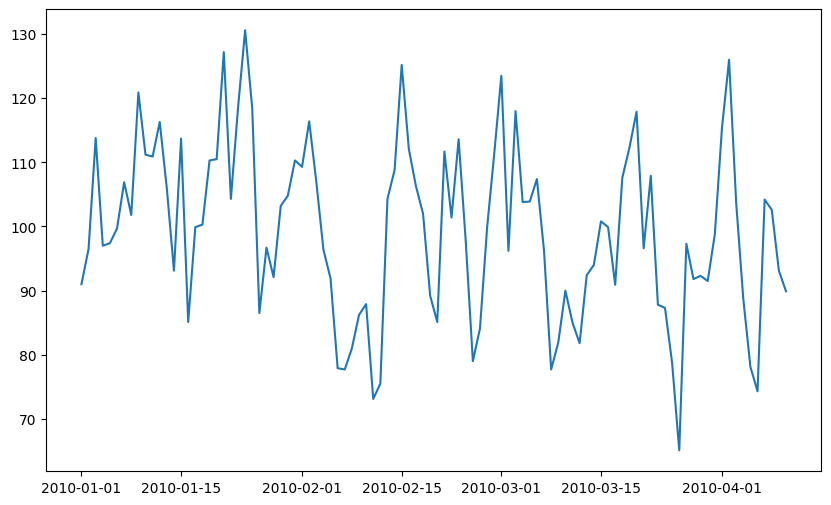

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
axes.plot(sales['date'], sales['sales'])
plt.show()

In [5]:
y = sales['sales'].values
T = len(y)

In [6]:
stan_data = {
    'T': T,
    'y': y
}

In [7]:
with open('../stan/4-7-AR-model.stan') as f:
    stan_code = f.read()

In [8]:
sm = stan.build(stan_code, data=stan_data, random_seed=123)

Building...

In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Core:215,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Dense:1,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:22,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:4,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /root/.cache/httpstan/4.12.0/models/rfioy6tq/model_rfioy6tq.cpp:2:
/usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/src/Core/arch/NEON/PacketMath.h: In function ‘Packet Eigen::internal::pload(const typename unpacket_traits<T>::type*) [with Packet = eigen_packet_wrapper<int, 2>; typename unpacket_traits<T>::type = signed char]’:
/usr/local/lib/python3.11/


Building: 21.3s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [9]:
fit = sm.sample(num_chains=3, num_samples=9000, num_warmup=1000, num_thin=3)

Sampling:   0%
Sampling:  33% (10000/30000)
Sampling:  67% (20000/30000)
Sampling: 100% (30000/30000)
Sampling: 100% (30000/30000), done.
Messages received during sampling:
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!


ARモデルは時系列データの弱定常過程を過程しているので、トレンドがあるデータについては差分を取るなどしてデータを定常過程にする必要がある。

また、状態空間モデルと違い、観測値から直接モデル化しているため結果の解釈も難しくなる。